# <font color='blue'>REVENUE FORECASTING MODEL WALKTHROUGH</font> 

## 1. Introduction 

This generic solution playbook runs a Demand Forecast model using advanced Machine Learning techniques. The solution depicts the end to end ML life-cycle such as data preprocessing, filteration, feature engineering, HyperParameter Tuning and the trained model. This notebook depicts the possibility to try several Machine Learning models that can be applied to time series data that results in various levels of forecast accuracy. The production ready model is finalised based on the least RMSE

Data: The data used for solution proposition is 3 years of sales information at the product level .

Model: Cnn-1D  

## 2. Data Exploration 

The data is retail company's sales information of grocery products at the UPC level, for which the revenue forecasting has to be done, the details of upc are given below:

**Import libraries**

In [47]:
import numpy as np
import pandas as pd
import pandas_profiling as pdp

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
sns.set()

import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from pandas.plotting import autocorrelation_plot
import statistics as st
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import fbprophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_yearly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GRU
from keras.layers import concatenate

In [25]:
data = pd.read_csv("data.csv", parse_dates = ["date_of_sale"], error_bad_lines=False)
data.head()

,Unnamed: 0,upc,date_of_sale,store_id,departmentname,categoryname,net_sales,count
0,0,25097000000,2017-11-22,2,Bakery,Viktor Benes/ Renaud Bakery,12.28,790168
1,1,25097000000,2017-01-30,2,Bakery,Viktor Benes/ Renaud Bakery,9.50,790168
2,2,25097000000,2016-04-11,2,Bakery,Viktor Benes/ Renaud Bakery,2.75,790168
3,3,25097000000,2017-07-02,2,Bakery,Viktor Benes/ Renaud Bakery,8.77,790168
4,4,25097000000,2018-05-07,2,Bakery,Viktor Benes/ Renaud Bakery,11.45,790168


In [26]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [28]:
data.departmentname.unique()

array(['Bakery', 'Produce'], dtype=object)

In [29]:
data.categoryname.unique()

array(['Viktor Benes/ Renaud Bakery', 'Hard Fruit'], dtype=object)

In [30]:
data.upc.value_counts()

25097000000    790168
4053           748304
Name: upc, dtype: int64

**For Data Preprocessing the trend and seasonality is captured for a few top UPC's as the first step in Data Exploration. This notebook will show findings in the context of the top selling UPC (Second row in the above; 25097000000)**

In [31]:
data = data[data.upc == 25097000000]
data.head()

,upc,date_of_sale,store_id,departmentname,categoryname,net_sales,count
0,25097000000,2017-11-22,2,Bakery,Viktor Benes/ Renaud Bakery,12.28,790168
1,25097000000,2017-01-30,2,Bakery,Viktor Benes/ Renaud Bakery,9.50,790168
2,25097000000,2016-04-11,2,Bakery,Viktor Benes/ Renaud Bakery,2.75,790168
3,25097000000,2017-07-02,2,Bakery,Viktor Benes/ Renaud Bakery,8.77,790168
4,25097000000,2018-05-07,2,Bakery,Viktor Benes/ Renaud Bakery,11.45,790168


**As the data is not in order, sort it based on the date to be considered - in our case it is the date_of_sale**

In [32]:
data = data.sort_values(by='date_of_sale')
data.head(10)

,upc,date_of_sale,store_id,departmentname,categoryname,net_sales,count
753730,25097000000,2016-01-03,8,Bakery,Viktor Benes/ Renaud Bakery,7.50,790168
253378,25097000000,2016-01-03,3,Bakery,Viktor Benes/ Renaud Bakery,28.25,790168
405917,25097000000,2016-01-03,8,Bakery,Viktor Benes/ Renaud Bakery,5.75,790168
79931,25097000000,2016-01-03,3,Bakery,Viktor Benes/ Renaud Bakery,1.90,790168
119572,25097000000,2016-01-03,3,Bakery,Viktor Benes/ Renaud Bakery,11.45,790168
537964,25097000000,2016-01-03,3,Bakery,Viktor Benes/ Renaud Bakery,16.50,790168
124578,25097000000,2016-01-03,18,Bakery,Viktor Benes/ Renaud Bakery,7.50,790168
112575,25097000000,2016-01-03,5,Bakery,Viktor Benes/ Renaud Bakery,20.18,790168
410817,25097000000,2016-01-03,2,Bakery,Viktor Benes/ Renaud Bakery,27.00,790168
77617,25097000000,2016-01-03,19,Bakery,Viktor Benes/ Renaud Bakery,12.50,790168


**Set the date column as index**

In [33]:
data.set_index(data["date_of_sale"],inplace=True)

In [34]:
data.index = pd.to_datetime(data.index)

## 3. Data Preprocessing

### Bucketization 
To achieve consistency and observe comprehendable seasonality, trends, and residual patterns, the data can be aggregated or bucketized on a daily or a weekly basis at the product level

In [35]:
daily_bucket = data["net_sales"].resample("D").sum()

In [36]:
daily_bucket.shape

(972,)

In [37]:
daily_bucket.head()

date_of_sale
2016-01-03    8223.23
2016-01-04    7021.80
2016-01-05    6610.42
2016-01-06    6445.34
2016-01-07    7195.91
Freq: D, Name: net_sales, dtype: float64

**Graph of daily sales of best-selling product**

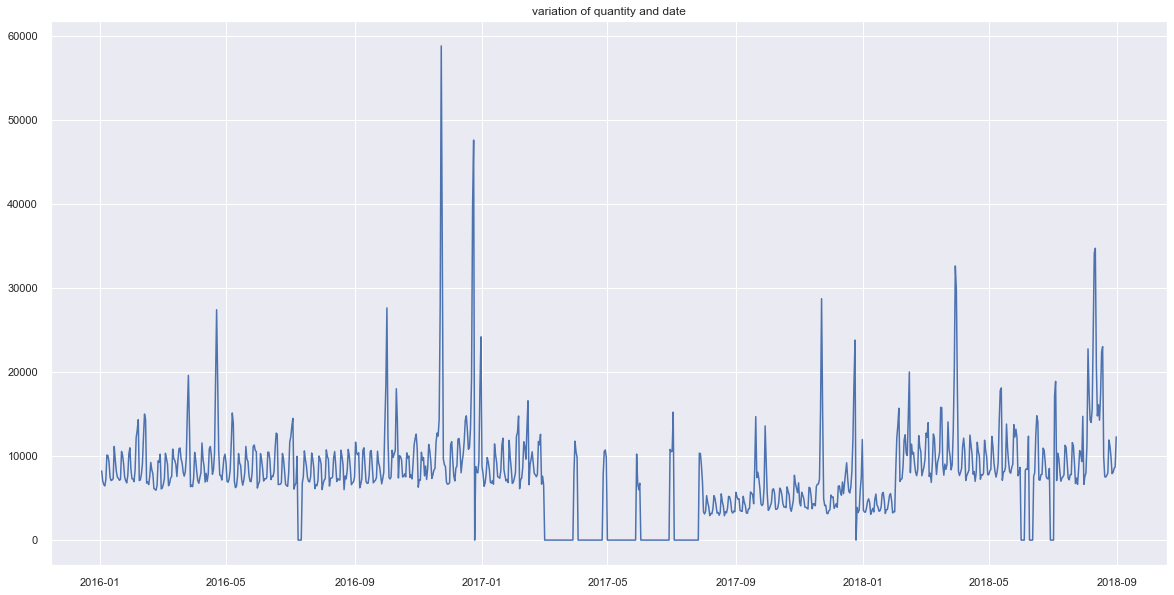

In [38]:
plt.plot(daily_bucket)
plt.title("variation of netsales and date")
fig = plt.gcf() 
fig.set_size_inches(20,10)
plt.show()

**Graph for mean and standard deviation based on daily bucket**

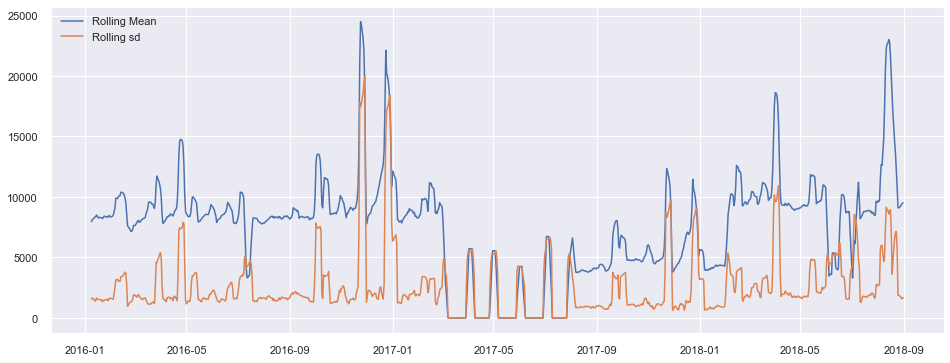

In [39]:
plt.figure(figsize=(16,6))
plt.plot(daily_bucket.rolling(window=7, center=False).mean(), label='Rolling Mean')
plt.plot(daily_bucket.rolling(window=7, center=False).std(), label='Rolling sd')
plt.legend()
plt.show()

**Graph showcasing the trend, seasonality and residual for sales**

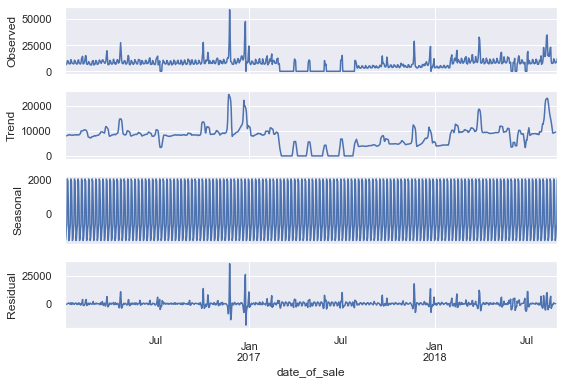

In [40]:
db_factors_weekly = sm.tsa.seasonal_decompose(daily_bucket, freq = 7, model = "autoregressive")
db_factors_weekly.plot();

**Weekly bucketization of the data**

In [41]:
weekly_bucket = data['net_sales'].resample('W').sum()
weekly_bucket.head()

date_of_sale
2016-01-03     8223.23
2016-01-10    56751.71
2016-01-17    57921.07
2016-01-24    58856.85
2016-01-31    58674.45
Freq: W-SUN, Name: net_sales, dtype: float64

**Graph for total sales of 1st sku based on weekly bucket**

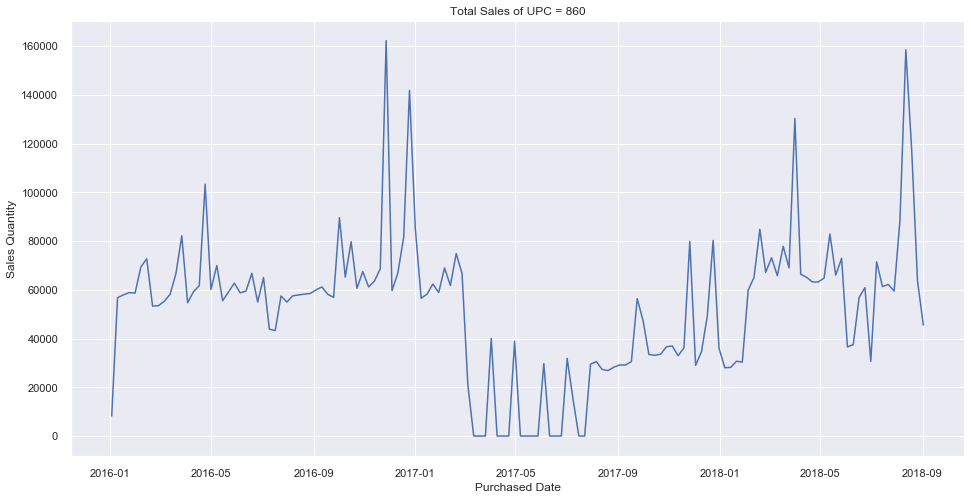

In [42]:
plt.figure(figsize=(16,8))
plt.title('Total Sales of UPC = 860')
plt.xlabel('Purchased Date')
plt.ylabel('Sales Quantity')
plt.plot(weekly_bucket)
plt.show()

**Graph showcasing the decomposition of sales when bucketized on a weekly basis**

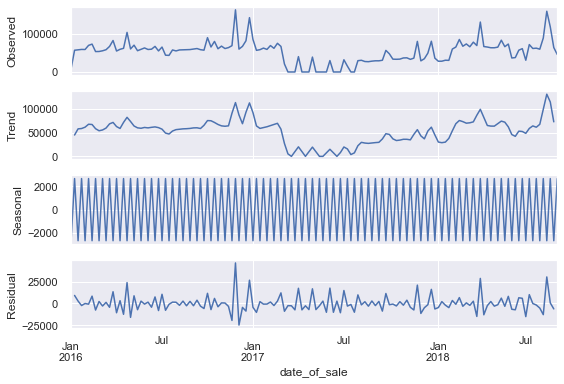

In [43]:
sm.tsa.seasonal_decompose(weekly_bucket, freq = 2, model = "autoregressive").plot();

## 4. Data Preparation 
### 4.1 AutoCorrelation and Partial AutoCorrelation to check the relationship between consecutive data in time series

**Graph showing small lags, we can see that we have a correlation of 0.73, which can be good for prediction purposes**

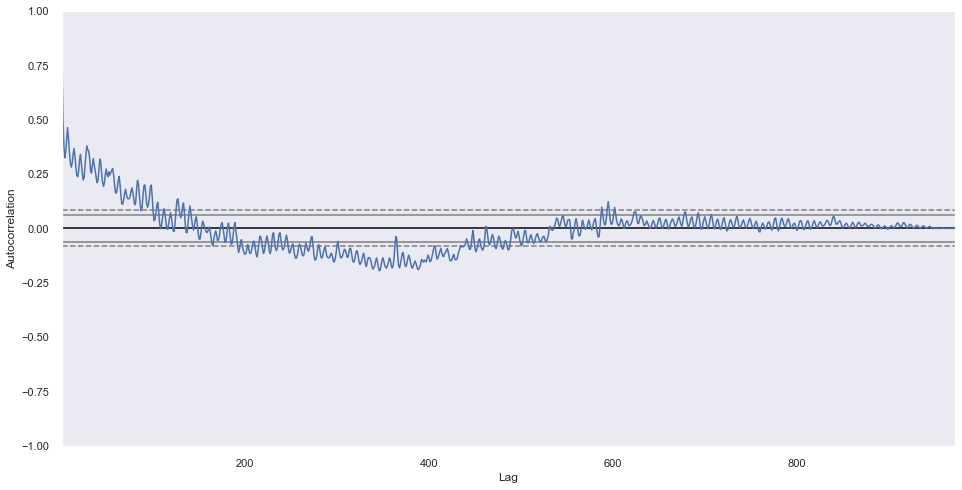

In [49]:
plt.figure(figsize=(16,8))
autocorrelation_plot(daily_bucket)
plt.show()

**Graph shows when lag is less, correlation exists for real. Also, you can see slight peaks, implying there is seasonality around 7**

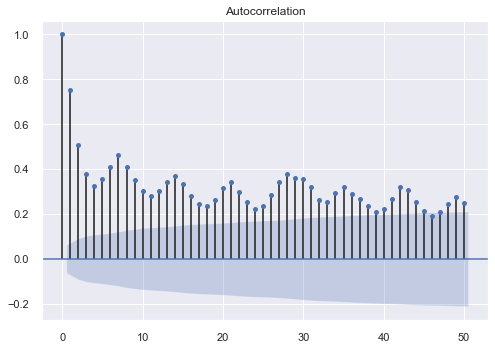

In [50]:
plot_acf(daily_bucket, lags = 50)
plt.show()

**Graph shows the strong partial auto correlation with lag = 1, not much there on**

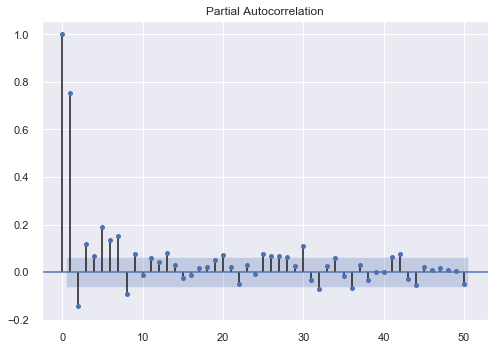

In [51]:
plot_pacf(daily_bucket, lags = 50)
plt.show()